Zadanie 01 - Klątwa wymiaru

Piotr Zawiślan

Celem zadania jest sprawdzenie jak zachowują się pewne wartości wraz ze wzrostem
wymiarowości przestrzeni. Na każde z zadanych pytań da się oczywiście odpowiedzieć poprzez
analityczne wyprowadzenie wzorów opisujących dane zależności. Tym razem chcemy jednak
poćwiczyć również pracę z niedeterministycznymi algorytmami (i raportowanie ich rezultatów) –
dlatego skorzystamy z metody Monte Carlo. Przyjmujemy też, że odległością jest zawsze odległość
Euklidesa.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple, Dict
%matplotlib inline

# Hipersześcian

Zapełniamy hipersześcian losowymi punktami o równomiernym rozkładzie (każdy punkt ma
taką samą szansę na bycie wylosowanym).

In [2]:
def sample_points_from_hypercube(n_samples: int, n_dim: int) -> np.ndarray:
    return np.random.rand(n_samples, n_dim)

In [3]:
test_points = sample_points_from_hypercube(300, 5)

## Kąt między wektorami

Z wygenerowanych punktów losujemy (bez zwracania) dwie pary. Punkty z każdej pary
wyznaczają pewien wektor (są jego początkiem i końcem). Jaki jest kąt między dwoma
wylosowanymi wektorami? Losowanie powtórz wielokrotnie. Jak wygląda rozkład
otrzymanych kątów?

In [4]:
def sample_vectors(points: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = np.random.choice(points.shape[0], 4, replace=False)
    return points[indices[0]] - points[indices[1]], points[indices[2]] - points[indices[3]]

In [5]:
def get_angle(v, u) -> float:
    v /= np.linalg.norm(v)
    u /= np.linalg.norm(u)
    return np.arccos(np.clip(np.dot(v, u), -1.0, 1.0))

In [6]:
v, u = sample_vectors(test_points)
angle = get_angle(v, u)

In [7]:
v, u

(array([-0.47901879,  0.17002   ,  0.43204953,  0.35487973,  0.65500212]),
 array([-0.78847858, -0.32526994,  0.1671309 , -0.18746027, -0.45763185]))

In [8]:
angle

1.5424657271867104

## Punkty wewnątrz kuli

Ponownie losujemy, ale tym razem tylko jedną parę. Pierwszy z wylosowanych punktów
wyznacza środek pewnej kuli, a odległość do drugiego z nich jest jej promieniem. Jaka część
wygenerowanych początkowo punktów znalazła się wewnątrz takiej kuli?

In [9]:
def sample_sphere(points: np.ndarray) -> Tuple[np.ndarray, float]:
    a, b = points[np.random.choice(points.shape[0], 2, replace=False)]
    return a, np.linalg.norm(a - b)

In [10]:
def get_points_inside_fraction(sphere: Tuple[np.ndarray, float], points: np.ndarray) -> float:
    a, r = sphere
    dist = np.linalg.norm(points - a, axis=1)
    return dist[dist < r].shape[0] / points.shape[0]

In [11]:
test_sphere = sample_sphere(test_points)

In [12]:
test_f = get_points_inside_fraction(test_sphere, test_points)

In [13]:
test_f

0.44333333333333336

## Trzy punkty i różnica odległości

Wylosujmy jeden punkt, a następnie parę innych punktów (łącznie 3 punkty). Obliczmy
odległość między startowym punktem i każdym z dwóch pozostałych. Jakim % średniej z tych
dwóch odległości jest różnica między nimi?

In [14]:
def get_mean_diff_frac(points: np.ndarray) -> float:
    a, x, y = points[np.random.choice(points.shape[0], 3, replace=False)]
    d_x = np.linalg.norm(x - a)
    d_y = np.linalg.norm(y - a)
    mean_x_y = (d_x + d_y) / 2.
    diff = np.abs(d_x - d_y)
    return diff / mean_x_y

In [15]:
get_mean_diff_frac(test_points)

0.13578543924453707

Każdą z tych kwestii rozpatrujemy wielokrotnie.

- Po pierwsze: musimy powtórzyć eksperyment dla każdej rozważanej liczby wymiarów, by
możliwe było zaobserwowanie jak wymiarowość wpływa na rezultaty.

- Po drugie: dla tej samej liczby wymiarów eskperyment również musi być powtórzony
wielokrotnie, gdyż wynik jednego losowania nie jest miarodajny

In [34]:
def get_datasets(n_dim_max: int, n_samples_hc=20000, n_rows_each=2000) \
                                    -> Dict[int, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    data_dict = {"angles": np.empty((n_rows_each, 2)), 
                 "sphere_frac": np.empty((n_rows_each, 2)), 
                 "diff_mean_frac": np.empty((n_rows_each, 2))}
    
    data_dict["angles"][:] = np.nan
    data_dict["sphere_frac"][:] = np.nan
    data_dict["diff_mean_frac"][:] = np.nan
    
    for n_dim in range(2, n_dim_max + 1):
        if n_dim % 5 == 0:
            print(f"current n_dim: {n_dim} / {n_dim_max}")
        points = sample_points_from_hypercube(n_samples_hc, n_dim)
        
        # angles
        angle_arr = np.array([get_angle(*sample_vectors(points)) for _ in range(n_rows_each)])
        
        # inside sphere fractions
        inside_sphere_arr = np.array([get_points_inside_fraction(sample_sphere(points), points) 
                                      for _ in range(n_rows_each)])
        
        # diff / mean fractions
        diff_mean_arr = np.array([get_mean_diff_frac(points) for _ in range(n_rows_each)])
        
        data_dict["angles"] = np.c_[data_dict["angles"], angle_arr]
        data_dict["sphere_frac"] = np.c_[data_dict["sphere_frac"], inside_sphere_arr]
        data_dict["diff_mean_frac"] = np.c_[data_dict["diff_mean_frac"], diff_mean_arr]
        
    return data_dict

In [35]:
result_dict = get_datasets(n_dim_max=60)

current n_dim: 5 / 60
current n_dim: 10 / 60
current n_dim: 15 / 60
current n_dim: 20 / 60
current n_dim: 25 / 60
current n_dim: 30 / 60
current n_dim: 35 / 60
current n_dim: 40 / 60
current n_dim: 45 / 60
current n_dim: 50 / 60
current n_dim: 55 / 60
current n_dim: 60 / 60


In [36]:
angles_df = pd.DataFrame(result_dict["angles"])
angles_df = angles_df.drop(labels=[0, 1], axis=1)
angles_df

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,60
0,2.756584,1.853947,1.529165,1.874181,2.501418,1.324408,1.570864,1.563153,1.497370,1.930111,...,1.448701,1.607880,1.520904,1.567543,1.683087,1.637273,1.581654,1.595091,1.759142,1.701294
1,2.941123,2.221015,1.727547,1.294435,1.668596,1.516143,1.200390,2.178219,1.150198,1.449399,...,1.700308,1.378485,1.564930,1.553938,1.456769,1.676809,1.609090,1.504712,1.664513,1.479605
2,1.296709,2.046049,0.933638,1.868196,1.182746,2.166515,1.553428,1.635658,1.715225,2.018749,...,1.840331,1.785321,1.409209,1.523922,1.489611,1.546587,1.586237,1.599592,1.720410,1.627176
3,2.790884,1.687547,1.967654,1.872121,1.881068,1.368840,1.648087,1.479634,1.440443,1.831948,...,1.549814,1.574907,1.655265,1.706932,1.665009,1.839811,1.527942,1.476480,1.486834,1.386280
4,0.177585,1.253434,2.653747,2.331003,1.786313,1.349303,1.732386,0.838292,1.792307,1.410987,...,1.658481,1.568426,1.402790,1.563178,1.329607,1.500679,1.342825,1.364826,1.410942,1.514733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.675132,0.107488,1.774181,1.483706,1.099984,1.853013,1.872066,1.782023,1.482317,2.158209,...,1.664159,1.338824,1.459921,1.673145,1.507116,1.440040,1.683315,1.170471,1.697255,1.605778
1996,0.682102,1.232474,1.729463,1.594392,1.553182,1.188021,1.852365,1.590372,2.182196,0.882219,...,1.710255,1.880174,1.452048,1.727436,1.626366,1.499049,1.505243,1.498848,1.401980,1.601840
1997,0.063386,0.985199,1.733833,2.219709,2.111645,2.015177,1.657039,1.572655,1.413282,1.752925,...,1.436878,1.452379,1.340657,1.653346,1.541534,1.622516,1.604591,1.609015,1.503671,1.195166
1998,2.874078,2.042123,2.307450,2.142843,0.671083,1.498116,1.959601,1.989681,1.194419,0.979013,...,1.570243,1.619895,1.520828,1.367172,1.408930,1.532747,1.364493,1.650126,1.572778,1.627001


In [37]:
sphere_df = pd.DataFrame(result_dict["sphere_frac"])
sphere_df = sphere_df.drop(labels=[0, 1], axis=1)
sphere_df

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,60
0,0.17630,0.17035,0.52780,0.02400,0.35650,0.74260,0.95550,0.83630,0.11215,0.16205,...,0.57090,0.75335,0.39700,0.29340,0.93560,0.79220,0.50435,0.94375,0.12140,0.67650
1,0.62115,0.44475,0.15905,0.50060,0.11905,0.84345,0.86535,0.67325,0.07440,0.05020,...,0.57350,0.41955,0.84545,0.81140,0.25680,0.78435,0.70915,0.75350,0.01515,0.34015
2,0.29050,0.97155,0.69215,0.29215,0.72500,0.28130,0.95945,0.73840,0.07510,0.41490,...,0.31490,0.54825,0.33810,0.76920,0.59690,0.53570,0.99830,0.18595,0.72785,0.83915
3,0.52795,0.98915,0.68255,0.95335,0.90765,0.96465,0.45495,0.05330,0.51035,0.52615,...,0.00930,0.02635,0.64745,0.98180,0.69165,0.77960,0.50055,0.72835,0.61250,0.33070
4,0.16820,0.31655,0.56210,0.14360,0.10890,0.70910,0.37950,0.59115,0.69195,0.42955,...,0.68935,0.82410,0.29310,0.75290,0.61745,0.29130,0.34170,0.52070,0.88880,0.71110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.78940,0.99440,0.87850,0.57755,0.83335,0.17910,0.40425,0.04085,0.82780,0.74780,...,0.55175,0.28725,0.02200,0.28980,0.02690,0.81140,0.30980,0.48400,0.66225,0.93460
1996,0.57025,0.38795,0.25285,0.37690,0.55095,0.81595,0.71840,0.48070,0.09010,0.10925,...,0.68800,0.07435,0.07675,0.34685,0.20675,0.96935,0.33455,0.62555,0.92370,0.18440
1997,0.23205,0.81875,0.36955,0.54435,0.52520,0.94865,0.83475,0.11280,0.33350,0.49250,...,0.02370,0.92960,0.32570,0.09115,0.06005,0.13350,0.08560,0.48775,0.72545,0.10780
1998,0.68885,0.22900,0.22850,0.52275,0.96725,0.36430,0.34870,0.48955,0.24365,0.31565,...,0.87835,0.55545,0.74290,0.45600,0.81710,0.45695,0.75490,0.25260,0.10920,0.38325


In [38]:
diff_mean_df = pd.DataFrame(result_dict["diff_mean_frac"])
diff_mean_df = diff_mean_df.drop(labels=[0, 1], axis=1)
diff_mean_df

,2,3,4,5,6,7,8,9,10,11,...,51,52,53,54,55,56,57,58,59,60
0,0.221549,0.534900,0.137461,0.320865,0.310337,0.490097,0.099684,0.104602,0.321378,0.814898,...,0.233321,0.075913,0.037143,0.054067,0.138420,0.010386,0.231023,0.113954,0.189525,0.078682
1,1.210635,0.145195,0.611576,0.009129,0.352491,0.103751,0.238860,0.023844,0.233491,0.184219,...,0.083860,0.055081,0.119441,0.141423,0.018065,0.017131,0.189703,0.006535,0.033560,0.086546
2,0.276330,0.345766,0.699202,0.335095,0.239507,0.406968,0.245497,0.030537,0.250066,0.023843,...,0.144732,0.177612,0.038711,0.107370,0.088389,0.071828,0.037200,0.228068,0.013883,0.114411
3,0.351951,0.077573,0.743053,0.050332,0.423718,0.039066,0.104881,0.435403,0.285602,0.172892,...,0.096155,0.133861,0.150293,0.149012,0.024107,0.156760,0.036041,0.158300,0.105702,0.044188
4,0.022956,0.071323,0.143980,0.306896,0.192441,0.145666,1.160919,0.199160,0.268644,0.301910,...,0.027457,0.250624,0.122917,0.041972,0.061582,0.011554,0.059973,0.070406,0.018292,0.005863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.421096,0.448813,0.105040,0.059315,0.880339,0.969659,0.198940,0.186156,0.162333,0.153998,...,0.044023,0.004871,0.025380,0.161471,0.074848,0.065631,0.021506,0.124754,0.209541,0.098654
1996,1.298422,0.062129,0.050479,0.815434,0.104840,0.182751,0.621935,0.233782,0.023254,0.075125,...,0.076563,0.019957,0.009782,0.290647,0.110834,0.057898,0.041820,0.011975,0.141315,0.011963
1997,0.819071,0.066738,0.024724,0.417993,0.165506,0.011564,0.285102,0.234522,0.340264,0.281472,...,0.000220,0.031029,0.064035,0.005529,0.140840,0.106822,0.055114,0.042051,0.005618,0.063122
1998,1.163014,0.154788,0.139066,0.452390,0.036954,0.199521,0.071366,0.366609,0.407119,0.279604,...,0.135867,0.111950,0.156965,0.034064,0.089777,0.058392,0.012079,0.056711,0.061613,0.021369


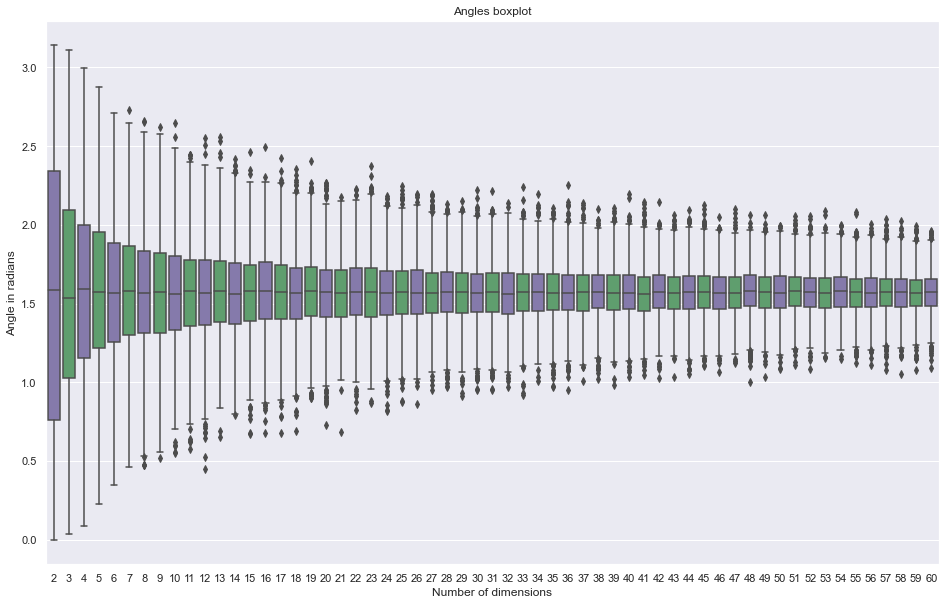

In [39]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(16, 10)})
sns.boxplot(palette=["m", "g"], data=angles_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Angle in radians")
plt.title("Angles boxplot")
plt.show()

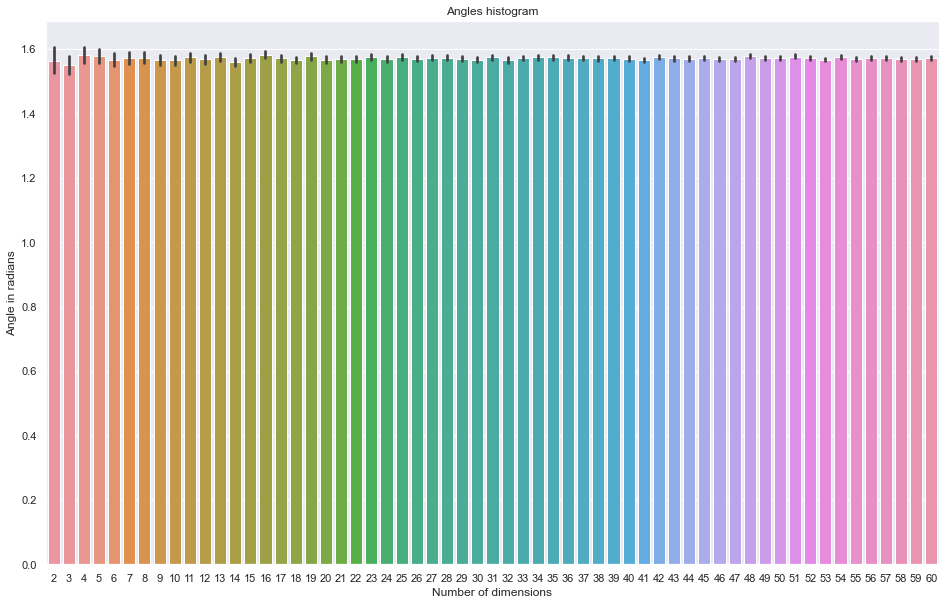

In [40]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16, 10)})
sns.barplot(data=angles_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Angle in radians")
plt.title("Angles histogram")
plt.show()

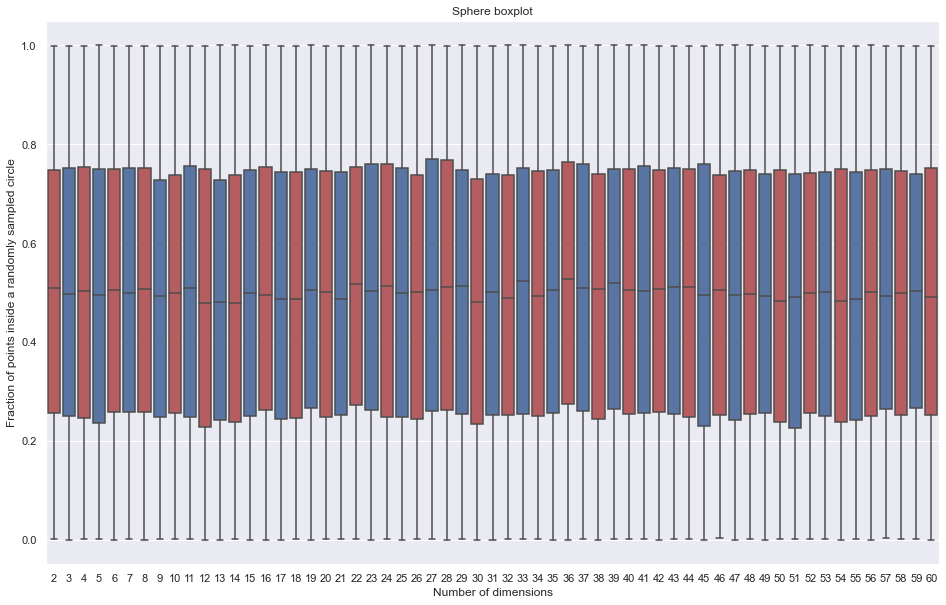

In [41]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(16, 10)})
sns.boxplot(palette=["r", "b"], data=sphere_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of points inside a randomly sampled circle")
plt.title("Sphere boxplot")
plt.show()

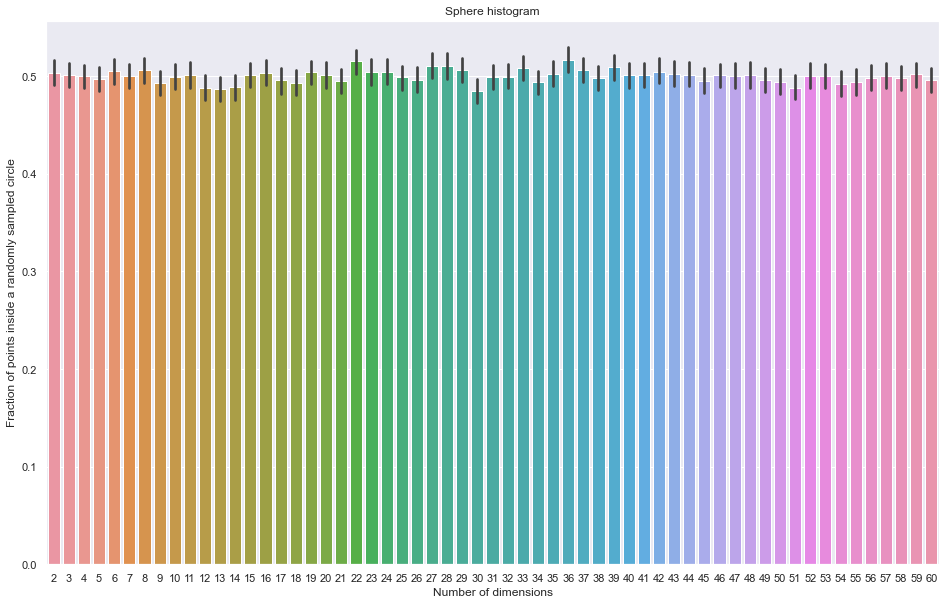

In [42]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16, 10)})
sns.barplot(data=sphere_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of points inside a randomly sampled circle")
plt.title("Sphere histogram")
plt.show()

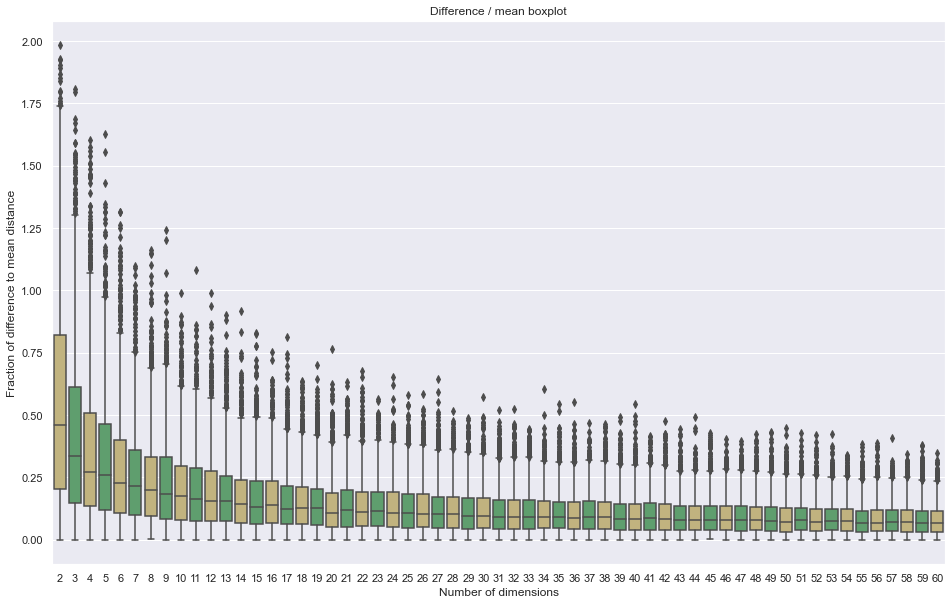

In [43]:
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(16, 10)})
sns.boxplot(palette=["y", "g"], data=diff_mean_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of difference to mean distance")
plt.title("Difference / mean boxplot")
plt.show()

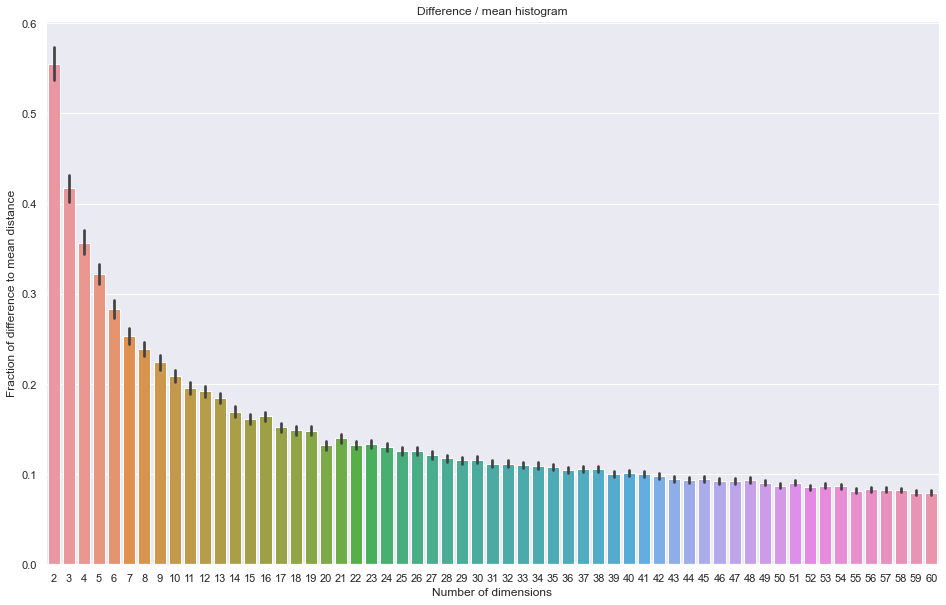

In [44]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16, 10)})
sns.barplot(data=diff_mean_df)
plt.xlabel("Number of dimensions")
plt.ylabel("Fraction of difference to mean distance")
plt.title("Difference / mean histogram")
plt.show()

Dla wszystkich podpunktów tworzymy odpowiednie wykresy (liniowy, punktowy, histogram - co
akurat pasuje), dobierając rozsądny (pozwalający na skończenie obliczeń tego samego wieczora ;])
zakres badanych wymiarów i liczbę punktów generowanych we wnętrzach sześcianów. W
konsekwencji - typowy wykres powinien przedstawiać średni rezultat z rozsądnej liczby powtórzeń
eksperymentu oraz jego odchylenie standardowe, zaprezentowane jako tzw. error-bars (tylko w
ten sposób można wiarygodnie przedstawiać informacje z obserwacji zjawisk losowych). Na
przyszłość przypominam również o podpisywaniu osi i uwzględnianiu informacji o jednostkach
(jeżeli takowe występują). Warto wykorzystać zadanie jako pretekst do oswojenia się z wybraną
biblioteką do rysowania wykresów (jeżeli takiej jeszcze nie mamy).

PS. Przypominam, że w ramach zadania wrzucamy raport w formacie PDF i ZIP z kodem.